- SUCH 2022
- WITH TRANSPORTATION AT ALL CPs

In [1]:
import pandas as pd
import numpy as np
import requests
import ast
import json
import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import datetime
import tqdm

from dotenv import load_dotenv

from utils.googlemaps.api import gm_distance_api, chunks
from utils.reporting.reports import getRouteReport
from utils.gtsp.GTSPutils import createDistanceMatrix, createDummyNode, createClusters, createGTSPfile, loadOptimalTour, reOrderTour
from utils.gpsconversion.conversionapi import convertWSG84toMN95

# LOAD ENV VARIABLES

In [2]:
load_dotenv()

DATA_PATH = os.environ['DATA_PATH']

# IMPORT COORDS

In [3]:
with open(os.path.join(DATA_PATH, 'CHECKPOINTS', 'mandatory_checkpoints.json'), 'r') as file:
    mandatory_checkpoints = json.load(file)
    
mandatory_checkpoints = {k: ast.literal_eval(v) for k, v in mandatory_checkpoints.items()}

with open(os.path.join(DATA_PATH, 'CHECKPOINTS', 'target_coords.json'), 'r') as file:
    target_coords = json.load(file)
    
target_coords= {k: ast.literal_eval(v) for k, v in target_coords.items()}

In [4]:
mandatory_checkpoints

{'st_imier_haut': (47.158679, 6.992699),
 'st_imier_bas': (47.15127, 6.99283),
 'lenzerheide_haut': (46.72093, 9.530324),
 'lenzerheide_bas_lift': (46.724895, 9.547017),
 'lenzerheide_bas_sporz': (46.715323, 9.540237),
 'beckenried': (46.967084, 8.475212),
 'gersau': (46.990807, 8.525738),
 'goschenen': (46.665698, 8.588439),
 'sanetsch': (46.363102, 7.295129)}

In [5]:
checkpoints = mandatory_checkpoints.copy()
checkpoints.update(target_coords)

In [6]:
checkpoints

{'st_imier_haut': (47.158679, 6.992699),
 'st_imier_bas': (47.15127, 6.99283),
 'lenzerheide_haut': (46.72093, 9.530324),
 'lenzerheide_bas_lift': (46.724895, 9.547017),
 'lenzerheide_bas_sporz': (46.715323, 9.540237),
 'beckenried': (46.967084, 8.475212),
 'gersau': (46.990807, 8.525738),
 'goschenen': (46.665698, 8.588439),
 'sanetsch': (46.363102, 7.295129),
 'versoix': (46.295182, 6.167042),
 'mies': (46.296179, 6.168144),
 'st_maurice': (46.223444, 7.003184),
 'diablerets': (46.361971, 7.228706),
 'rougemont': (46.486861, 7.228648),
 'chatel_st_denis': (46.512836, 6.911657),
 'vaumarcus': (46.870955, 6.754053),
 'chaux_de_fond': (47.122309, 6.885278),
 'chasseral': (47.125755, 7.038184),
 'delemont': (47.375549, 7.3615),
 'liesberg': (47.397281, 7.400262),
 'liesberg_2': (47.402422, 7.443518),
 'basel': (47.535692, 7.609889),
 'kaiseraugst': (47.536199, 7.721017),
 'kaiserstuhl': (47.564849, 8.420254),
 'aadorf': (47.494296, 8.894507),
 'wil': (47.466492, 9.029698),
 'herisau': (4

# IMPORT CP OPENING TIMES

In [ ]:
with open(os.path.join(DATA_PATH, 'CHECKPOINTS', 'cp_opening_times.json'), 'w') as outfile:

    json.dump(cp_opening_times, outfile, indent=4, default=str)

In [ ]:
with open(os.path.join(DATA_PATH, 'CHECKPOINTS', 'cp_opening_times.json'), 'r') as file:
    cp_opening_times = json.load(file)
    
#cp_opening_times = {k: ast.literal_eval(v) for k, v in cp_opening_times.items()}

In [7]:
cp_opening_times = {'st_imier_bas': [datetime.datetime.strptime('7/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('7/9/2022 23:10', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 23:10', '%d/%m/%Y %H:%M')],
                    'st_imier_haut': [datetime.datetime.strptime('7/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('7/9/2022 23:10', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 23:10', '%d/%m/%Y %H:%M')], 
                    'lenzerheide_haut': [datetime.datetime.strptime('7/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')],
                    'lenzerheide_bas_lift': [datetime.datetime.strptime('7/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')],
                    'lenzerheide_bas_sporz': [datetime.datetime.strptime('7/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')],
                    'beckenried': [datetime.datetime.strptime('7/9/2022 07:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('7/9/2022 18:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('8/9/2022 07:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('8/9/2022 18:40', '%d/%m/%Y %H:%M')],
                    'gersau': [datetime.datetime.strptime('7/9/2022 07:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('7/9/2022 18:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('8/9/2022 07:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('8/9/2022 18:00', '%d/%m/%Y %H:%M')],
                    'goschenen': [datetime.datetime.strptime('7/9/2022 06:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('7/9/2022 21:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('8/9/2022 06:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('8/9/2022 21:51', '%d/%m/%Y %H:%M')],
                    'sanetsch': [datetime.datetime.strptime('7/9/2022 08:30', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 08:30', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')]}

# LOAD CLUSTER MAPPING

In [8]:
with open(os.path.join(DATA_PATH, 'CHECKPOINTS', 'cluster_mapping.json'), 'r') as file:
    cluster_mapping = json.load(file)

# RUN CELL WITH DIFFERENT START POINTS TO GENERATE REPORTS

  0%|                                                                                                                                                               | 0/2 [00:00<?, ?it/s]


--------- Problem Data ------------
Instance Name      : test_2022.gtsp
Number of Vertices : 47
Number of Sets     : 33
Initial Tour       : Random
Maximum Removals   : 10
Trials             : 5
Restart Attempts   : 3
Rate of Adaptation : 0.5
Prob of Reopt      : 1.0
Maximum Time       : 360
Tour Budget        : None
-----------------------------------

 |1=====2=====3=====4=====5=====|  Cost = 233627  Time = 0.3 sec      

--------- Tour Summary ------------
Cost              : 233627
Total Time        : 0.31 sec
Solver Timeout?   : false
Tour is Feasible? : true
Output File       : /Users/kieranschubert/Desktop/swiss-ultracycling-challenge/data/TOUR_FILES/tour_test_2022.txt
Tour Ordering     : printed to /Users/kieranschubert/Desktop/swiss-ultracycling-challenge/data/TOUR_FILES/tour_test_2022.txt
-----------------------------------


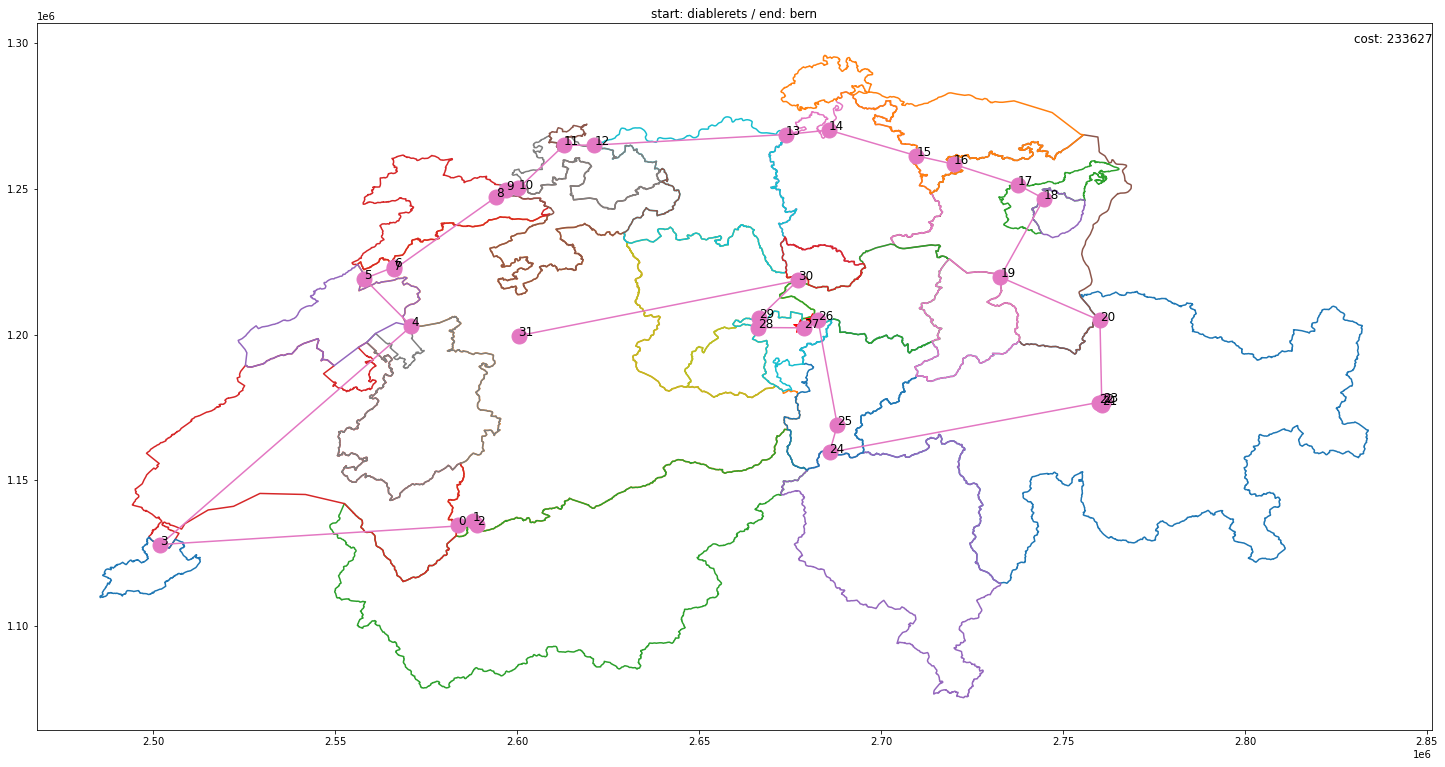

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 1/2 [00:05<00:05,  5.38s/it]


--------- Problem Data ------------
Instance Name      : test_2022.gtsp
Number of Vertices : 48
Number of Sets     : 33
Initial Tour       : Random
Maximum Removals   : 10
Trials             : 5
Restart Attempts   : 3
Rate of Adaptation : 0.5
Prob of Reopt      : 1.0
Maximum Time       : 360
Tour Budget        : None
-----------------------------------

ERROR: LoadError: BoundsError: attempt to access 33×48 Matrix{Int64} at index [0, 1]
Stacktrace:
 [1] getindex
   @ ./array.jl:862 [inlined]
 [2] set_vertex_dist(dist::Matrix{Int64}, num_sets::Int64, member::Vector{Int64})
   @ GLNS ~/.julia/packages/GLNS/4IFc9/src/utilities.jl:90
 [3] solver(problem_instance::String; args::Base.Pairs{Symbol, String, Tuple{Symbol}, NamedTuple{(:output,), Tuple{String}}})
   @ GLNS ~/.julia/packages/GLNS/4IFc9/src/GLNS.jl:43
 [4] top-level scope
   @ ~/Desktop/swiss-ultracycling-challenge/scripts/gtsp_solver.jl:2
in expression starting at /Users/kieranschubert/Desktop/swiss-ultracycling-challenge/script

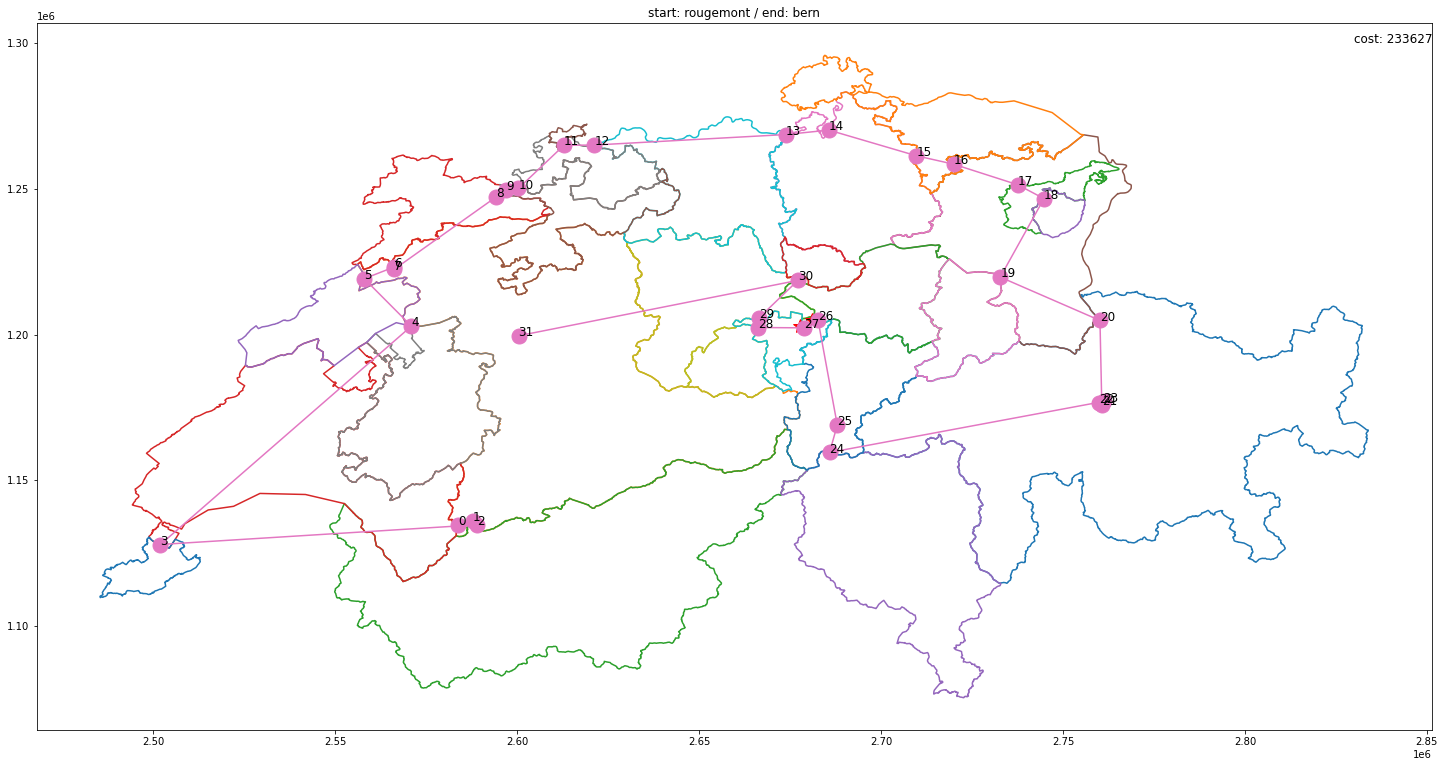

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.31s/it]


In [20]:
reports = []
reports_r = []
tour_costs = []

optimize = 'time'

use_transport = True
save_plot = False

end = 'bern'

data_version = '03'



# LOAD CANTONAL BORDER DATA
###########################################################################

df_cantons = gpd.read_file(os.path.join(DATA_PATH, 'SHP_FILES', 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp'))
cantons = df_cantons['NAME'].unique()

# DEFINE CP COORDS IN MN95 FORMAT
###########################################################################

cp_coord_x = [2588950.069, 2677691.166, 2680954.976, 2688009.628, 2566249.259, 2759952.968, 2600422.411]
cp_coord_y = [1134641.528, 1202811.284, 1205098.173, 1168980.565, 1223196.312, 1176579.977, 1199574.686]

# LOAD GM API DATA AND CREATE DISTANCE MATRIX
###########################################################################

if optimize == 'time':

    with open(os.path.join(DATA_PATH, 'DIST_MATRIX', f'api_data_time_{data_version}.json'), 'r') as file:
        api_data = json.load(file)
        
    df = createDistanceMatrix(api_data, use_transport=use_transport, optimize=optimize)
    
    with open(os.path.join(DATA_PATH, 'DIST_MATRIX', f'api_data_dist_{data_version}.json'), 'r') as file:
        api_data_distance = json.load(file)
        
    df_distance = createDistanceMatrix(api_data_distance, use_transport=use_transport, optimize='distance')

elif optimize == 'distance':

    with open(os.path.join(DATA_PATH, 'DIST_MATRIX', f'api_data_dist_{data_version}.json'), 'r') as file:
        api_data = json.load(file)
        
    df = createDistanceMatrix(api_data, use_transport=use_transport, optimize=optimize)
    
    df_distance = df.copy()

for start in tqdm.tqdm(list(checkpoints.keys())[12:14]):
    
    
    # CREATE DUMMY NODE
    ###########################################################################
    
    df = createDummyNode(df, start, end, checkpoints)
    
    # ADD CLUSTER
    ###########################################################################
    
    such_2022, clusters = createClusters(checkpoints, cluster_mapping)
    
    # CREATE GTSP FILE
    ###########################################################################

    createGTSPfile(df, clusters)
    
    # RUN JULIA SOLVER
    ###########################################################################

    !/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia ../scripts/gtsp_solver.jl
    
    # LOAD OPTIMAL TOUR
    ###########################################################################
    
    tour, tour_cost = loadOptimalTour('tour_test_2022.txt')
    
    tour_costs.append(tour_cost)

    # RE-ORDER OPTIMAL TOUR
    ###########################################################################

    tour_coord_x, tour_coord_y, df_tour = reOrderTour(such_2022, tour, cluster_mapping)

    # PLOT OPTIMAL TOUR
    ###########################################################################
    
    fig, ax = plt.subplots(figsize=(25,13))

    for canton in cantons:
        x_c, y_c = df_cantons[df_cantons['NAME']==canton]['geometry'].iloc[0].exterior.coords.xy
        x_c = list(x_c)[:-1]
        y_c = list(y_c)[:-1]
        ax.plot(x_c, y_c)

    ax.plot(cp_coord_x, cp_coord_y, 'r*', markersize=15)

    ax.plot(tour_coord_x, tour_coord_y, '-o', markersize=15)

    for i, (x, y) in enumerate(zip(tour_coord_x, tour_coord_y)):

        ax.text(x, y, i, fontsize='large')

    ax.text(2830000, 1300000, f'cost: {tour_cost}', fontsize='large')
    ax.set_title(f'start: {start} / end: {end}')

    if save_plot:
        
        plt.savefig(os.path.join(DATA_PATH, 'TOUR_VIZ', '2022', f'{start}_{end}_{tour_cost}.png'))
        
    plt.show()
    
    # CREATE REPORTS
    ###########################################################################
                    
    reports.append(getRouteReport(df_tour, df_distance, checkpoints, mandatory_checkpoints, cp_opening_times, avg_speed=26, reverse=False))
    reports_r.append(getRouteReport(df_tour, df_distance, checkpoints, mandatory_checkpoints, cp_opening_times, avg_speed=26, reverse=True))

In [17]:
reports[0]

,latitude,longitude,cluster,dist_km,cum_dist_km,time_h,elapsed_time_h,eta,elapsed_time_hrf,cp,opening_hours,transport
15,46.870955,6.754053,NE,0.000,0.000,0.000000,0.000000,2022-09-07 10:10:00.000000,0 days 00:00:00,vaumarcus,NaN,NaN
9,46.295182,6.167042,GE,92.616,92.616,3.562154,3.562154,2022-09-07 13:43:43.753846,0 days 03:33:43.753846,versoix,NaN,NaN
12,46.361971,7.228706,VD,117.633,210.249,4.524346,8.086500,2022-09-07 18:15:11.400000,0 days 08:05:11.400000,diablerets,NaN,NaN
36,46.375759,7.280778,BE,6.378,216.627,0.245308,8.331808,2022-09-07 18:29:54.507692,0 days 08:19:54.507692,gsteig,NaN,NaN
8,46.363102,7.295129,VS,108.762,325.389,4.183154,12.514962,2022-09-07 22:40:53.861538,0 days 12:30:53.861538,sanetsch,"[2022-09-07 08:30:00, 2022-09-07 17:00:00, 202...",NaN
33,46.529486,8.606202,TI,165.746,491.135,6.374846,18.889808,2022-09-08 05:03:23.307692,0 days 18:53:23.307692,airolo,NaN,NaN
7,46.665698,8.588439,UR,31.255,522.390,1.202115,20.091923,2022-09-08 06:15:30.923077,0 days 20:05:30.923077,goschenen,"[2022-09-07 06:51:00, 2022-09-07 21:51:00, 202...",NaN
6,46.990807,8.525738,SZ,52.628,575.018,2.024154,22.116077,2022-09-08 08:16:57.876923,0 days 22:06:57.876923,gersau,"[2022-09-07 07:00:00, 2022-09-07 18:00:00, 202...",Y
5,46.967084,8.475212,NW,54.832,629.850,2.108923,24.225000,2022-09-08 10:23:30.000000,1 days 00:13:30,beckenried,"[2022-09-07 07:40:00, 2022-09-07 18:40:00, 202...",Y
32,46.969442,8.310239,OW,15.019,644.869,0.577654,24.802654,2022-09-08 10:58:09.553846,1 days 00:48:09.553846,alpnach,NaN,NaN


In [ ]:
tour_costs = [int(x) for x in tour_costs]
plt.bar(range(len(tour_costs)), tour_costs)
plt.ylim(75000, 88000)
plt.show()

In [ ]:
np.where(np.array(tour_costs)==min(tour_costs))

In [ ]:
tour_costs_dist = []

for report, report_r in zip(reports, reports_r):
    
    if report.cum_dist_km.iloc[-1] > report_r.cum_dist_km.iloc[-1]:
        
        tour_costs_dist.append(report.cum_dist_km.iloc[-1])
    
    else:
        
        tour_costs_dist.append(report_r.cum_dist_km.iloc[-1])
        

plt.bar(range(len(tour_costs_dist)), [int(x) for x in tour_costs_dist])
plt.ylim(1000, 1350)
plt.show()

In [ ]:
np.where(tour_costs_dist==min(tour_costs_dist))

In [ ]:
reports[9]

- SET ALL TRANSPORTS TO ON
- THEN TEST ALL COMBINATIONS OF TRANSPORTS
- THEN SET ALL DIFFERENT DEPARTURE POINTS

- SUBTRACT TIME FOR TRANSPORTS
- RANK BEST ROUTES WRT TOTAL TIME
- ADD TARGET POINTS -> MAYBE WILL HELP FOR GSTEIG IF MORE POINTS IN BE

- compute all optimal routes from all possible start points
- for the shortest routes, compute all possible pairs of transports -> then check eta and feasability
- for the shortest routes, compute eta at each stop -> see if transport is feasible

- OTHER APPROACH: encore transport in distance matrix

- ELEVATION API ? 
- REQUIRE HALF MATRIX (SYMMETRY)
- COMPUTE DIFF(ALT1, ALT2) BETWEEN 2 POINTS
- ESTIMATE SPEEDS FOR ALL GRADIENTS -> DYNAMIC SPEED COMPUTATION

# CP TRANSPORTATION

In [ ]:
cp_transportation_time_costs = {'st_imier': 300,
                           'lenzerheide': 300,
                           'beckenried': 1200,
                           'gersau': 1200,
                           'goschenen': 900,
                           'sanetsch': 900}

### Set desired transportation

In [ ]:
cp1 = 'lenzerheide'
cp1_p = 'airolo'
cp2 = 'beckenried'
cp2_p = 'beckenried'

### Set cost to 0 in desired direction

In [ ]:
ind_cp1 = [x==cp1 for x in checkpoints.keys()]
ind_cp1 = np.where(ind_cp1)[0][0]
ind_cp1_p = [x==cp1_p for x in checkpoints.keys()]
ind_cp1_p = np.where(ind_cp1_p)[0][0]

ind_cp2 = [x==cp2 for x in checkpoints.keys()]
ind_cp2 = np.where(ind_cp2)[0][0]
ind_cp2_p = [x==cp2_p for x in checkpoints.keys()]
ind_cp2_p = np.where(ind_cp2_p)[0][0]

In [ ]:
# Set asymetric transportation cost
df.loc[ind_cp1, ind_cp1_p] = cp_transportation_time_costs[cp1]
df.loc[ind_cp2, ind_cp2_p] = cp_transportation_time_costs[cp2]

### Re-run optimisation

In [ ]:
try:
    os.remove('./GTSP_FILES/test_2022.gtsp')
except FileNotFoundError:
    pass

dim = len(df)
sets = len(clusters)

# WRITE PARAMS AND WEIGHTS TO FILE
params = f'NAME: such_test_3 \n\
TYPE: AGTSP \n\
COMMENT: test \n\
DIMENSION: {dim} \n\
GTSP_SETS: {sets} \n\
EDGE_WEIGHT_TYPE: EXPLICIT \n\
EDGE_WEIGHT_FORMAT: FULL_MATRIX \n\
EDGE_WEIGHT_SECTION \n\
{df.to_string(header=False, index=False)} \n\
GTSP_SET_SECTION: \n'

with open('./GTSP_FILES/test_2022.gtsp', 'a') as gtsp_file:
    gtsp_file.write(params)

# WRITE SET SECTION
outfile = open('./GTSP_FILES/test_2022.gtsp', 'a')

for cluster in clusters:
    out = str(cluster[0]) + ' ' + ' '.join([str(x) for x in cluster[1]]) + ' -1' + '\n'
    outfile.write(out)

outfile.close()

# WRITE EOF
with open('./GTSP_FILES/test_2022.gtsp', 'a') as gtsp_file:
    gtsp_file.write('EOF')

In [ ]:
!/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia ./gtsp_solver.jl

In [ ]:
with open('./TOUR_FILES/tour_test_2022.txt') as f:
    file = f.readlines()
    
tour = ast.literal_eval(file[-1].split(": ")[-1])
tour = [x-1 for x in tour]

tour_cost = file[6].split(': ')[-1].strip()

df_cantons = gpd.read_file("./swissboundaries/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp")
cantons = df_cantons['NAME'].unique()

cp_coord_x = [2588950.069, 2677691.166, 2680954.976, 2688009.628, 2566249.259, 2759952.968, 2600422.411]
cp_coord_y = [1134641.528, 1202811.284, 1205098.173, 1168980.565, 1223196.312, 1176579.977, 1199574.686]

In [ ]:
df_tour = such_2022.loc[tour].replace({v: k for k, v in cluster_mapping.items()}).iloc[::-1]

df_1 = df_tour.loc[df_tour[df_tour.cluster == 'DUMMY'].index[0]:].iloc[1:]
df_2 = df_tour.loc[:df_tour[df_tour.cluster == 'DUMMY'].index[0]].iloc[:-1]
df_tour = pd.concat([df_1, df_2])

df_tour.replace({0: 'latitude', 1: 'longitude'}, inplace=True)

such_2022.rename(columns={0: 'latitude', 1: 'longitude'}, inplace=True)

tour_coord_x = []
tour_coord_y = []

# need to reverse df order SOMETIMES
for i, coords in df_tour.iterrows():
#for i, coords in such_2022.loc[tour].iterrows():

    url = f'http://geodesy.geo.admin.ch/reframe/wgs84tolv95?easting={coords.longitude}&northing={coords.latitude}&format=json'
    res = requests.get(url)
    res = ast.literal_eval(res.content.decode('utf-8'))
    tour_coord_y.append(res['northing'])
    tour_coord_x.append(res['easting'])
    
tour_coord_x = [float(x) for x in tour_coord_x]
tour_coord_y = [float(y) for y in tour_coord_y]

### WITH TRANSPORT

In [ ]:
fig, ax = plt.subplots(figsize=(25,13))

for canton in cantons:
    x_c, y_c = df_cantons[df_cantons['NAME']==canton]['geometry'].iloc[0].exterior.coords.xy
    x_c = list(x_c)[:-1]
    y_c = list(y_c)[:-1]
    ax.plot(x_c, y_c)

ax.plot(cp_coord_x, cp_coord_y, 'r*', markersize=15)
    
ax.plot(tour_coord_x, tour_coord_y, '-o', markersize=15)

for i, (x, y) in enumerate(zip(tour_coord_x, tour_coord_y)):
    
    ax.text(x, y, i, fontsize='large')
    
ax.text(2830000, 1300000, f'cost: {tour_cost}', fontsize='large')
ax.set_title(f'start: {start} / end: {end}')

plt.savefig(f'./TOUR_VIZ/2022/WITH_TRANSPORT/{start}_{end}_{tour_cost}_t1_{cp1}_t2_{cp2}.png')
plt.show()

# TRANSPORTATION ETA CHECK

In [ ]:
cp_opening_times = {'st_imier': [datetime.datetime.strptime('7/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('7/9/2022 23:10', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 23:10', '%d/%m/%Y %H:%M')], 
                    'lenzerheide': [datetime.datetime.strptime('7/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')],
                    'beckenried': [datetime.datetime.strptime('7/9/2022 07:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('7/9/2022 18:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('8/9/2022 07:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('8/9/2022 18:40', '%d/%m/%Y %H:%M')],
                    'gersau': [datetime.datetime.strptime('7/9/2022 07:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('7/9/2022 18:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('8/9/2022 07:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('8/9/2022 18:00', '%d/%m/%Y %H:%M')],
                    'goschenen': [datetime.datetime.strptime('7/9/2022 06:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('7/9/2022 21:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('8/9/2022 06:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('8/9/2022 21:51', '%d/%m/%Y %H:%M')],
                    'sanetsch': [datetime.datetime.strptime('7/9/2022 08:30', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 08:30', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')]}

In [ ]:
### DIST
with open('./DIST_MATRIX/api_data_dist_00.json', 'r') as file:
    api_data = json.load(file)
    
df_transport = pd.DataFrame(np.zeros((len(api_data.keys()), len(api_data.keys()))))

for i, (key, val) in enumerate(api_data.items()):
    
    df_transport.loc[i, i] = 999999
    df_transport.loc[i, np.where(df_transport.loc[i]!=999999)[0]] = val
    

df_transport.replace({'ZERO_RESULTS': 999999}, inplace=True)

In [ ]:
n = 2  # group size
m = 1  # overlap size
l = list(df_tour.index)
tour_slices = [l[i:i+n] for i in range(0, len(l), n-m)][:-1]

# COMPUTE ETA AT CP
cum_dist = []
for ind in tour_slices:
    
    cum_dist.append(df_transport.iloc[ind[0], ind[1]])

avg_speed = 26
eta = np.cumsum([x/1000/avg_speed for x in cum_dist])

In [ ]:
def getRouteReport(df_tour):

    df_tour_eta = df_tour.copy()

    df_tour_eta['eta'] = np.insert(eta, 0, 0)
    start_time = datetime.datetime.strptime('7/9/2022 10:10', '%d/%m/%Y %H:%M')

    eta_timestamp_dt = [(start_time + datetime.timedelta(hours=t)) for t in eta]
    df_tour_eta['timestamp_dt'] = np.insert(eta_timestamp_dt, 0, start_time)

    df_tour_eta['elapsed_time'] = df_tour_eta.timestamp_dt.diff().fillna(pd.Timedelta(seconds=0)).cumsum()

    mc = {v: k for k, v in mandatory_checkpoints.items()}
    df_tour_eta['cp'] = [mc[(lat, lon)] if (lat, lon) in list(mandatory_checkpoints.values()) else np.nan for lat, lon in zip(df_tour_eta['latitude'], df_tour_eta['longitude'])]

    opening_hours = [cp_opening_times[mc[(lat, lon)]] if (lat, lon) in list(mc.keys()) else np.nan for lat, lon in zip(df_tour_eta['latitude'], df_tour_eta['longitude'])]
    df_tour_eta['opening_hours'] = opening_hours

    df_tour_eta['transport'] = ['Y' if (oh is not np.nan) and ((oh[0] < ts < oh[1]) or (oh[2] < ts < oh[3])) else np.nan for ts, oh in zip(df_tour_eta['timestamp_dt'], df_tour_eta['opening_hours'])]

    return df_tour_eta

In [ ]:
getRouteReport(df_tour)

In [ ]:
cp_transportation_dist_costs ={'st_imier': 2083,
                           'lenzerheide': 2083,
                           'beckenried': 8330,
                           'gersau': 8330,
                           'goschenen': 6250,
                           'sanetsch': 8330} 

In [ ]:
df_transport.loc[ind_cp1, ind_cp1_p] = cp_transportation_dist_costs[cp1]
df_transport.loc[ind_cp2, ind_cp2_p] = cp_transportation_dist_costs[cp2]

In [ ]:
pos_in_tour = np.where(df_tour.iloc[::-1].index==ind_cp1)[0]
start_time = datetime.datetime.strptime('7/9/2022 10:10', '%d/%m/%Y %H:%M')

# if cp at start, set cum_time to 0
if pos_in_tour-1 == -1:
    pos_in_tour = 0
    cp1_eta = start_time
else:
    cp1_eta = start_time + datetime.timedelta(hours=eta[pos_in_tour-1][0])
    

cp1_ontime = (cp_opening_times[cp1][0] < cp1_eta < cp_opening_times[cp1][1]) or (cp_opening_times[cp1][2] < cp1_eta < cp_opening_times[cp1][3])
cp1_ontime

In [ ]:
cp1_eta.strftime('%d/%m/%Y %H:%M')

In [ ]:
pos_in_tour = np.where(df_tour.iloc[::-1].index==ind_cp2)[0]

# if cp at start, set cum_time to 0
if pos_in_tour-1 == -1:
    pos_in_tour = 0
    cp2_eta = start_time
else:
    cp2_eta = start_time + datetime.timedelta(hours=eta[pos_in_tour-1][0])
    
cp2_ontime = (cp_opening_times[cp2][0] < cp2_eta < cp_opening_times[cp2][1]) or (cp_opening_times[cp2][2] < cp2_eta < cp_opening_times[cp2][3])
cp2_ontime

In [ ]:
cp2_eta.strftime('%d/%m/%Y %H:%M')

In [ ]:
transportation_eta = {'cp1': cp1,
                      'cp1_eta': cp1_eta.strftime('%d/%m/%Y %H:%M'),
                      'cp1_on_time': cp1_ontime,
                      'cp2': cp2,
                      'cp2_eta': cp2_eta.strftime('%d/%m/%Y %H:%M'),
                      'cp2_on_time': cp2_ontime,
                      'tour_cost': tour_cost}

with open(f'./TOUR_VIZ/2022/WITH_TRANSPORT/{start}_{end}_{tour_cost}_t1_{cp1}_t2_{cp2}.json', 'w') as outfile:
    json.dump(transportation_eta, outfile)

# Compute all possible starting points

In [ ]:
for start_point in ['goschenen', 'st_imier']:

    with open('./api_data_subset_targets_time.json', 'r') as file:
        api_data = json.load(file)

    # Create Distance Matrix
    df = pd.DataFrame(np.zeros((len(api_data.keys()), len(api_data.keys()))))

    for i, (key, val) in enumerate(api_data.items()):

        df.loc[i, i] = 999999
        df.loc[i, np.where(df.loc[i]!=999999)[0]] = val


    df.replace({'ZERO_RESULTS': 999999}, inplace=True)

    ### Set start point
    df[len(df)] = 999999
    df.loc[len(df)] = 999999

    ind_start = [x==start_point for x in checkpoints.keys()]
    ind_start = np.where(ind_start)[0][0]

    end = 'bern'
    ind_end = [x==end for x in checkpoints.keys()]
    ind_end = np.where(ind_end)[0][0]

    # 0 for dummy-dummy
    df.loc[len(df)-1, len(df)-1] = 0

    # 0 for start-end and end-start
    df.loc[ind_start, len(df)-1] = 0
    df.loc[ind_end, len(df)-1] = 0
    df.loc[len(df)-1, ind_start] = 0
    df.loc[len(df)-1, ind_end] = 0

    df = df.astype('int')
    
    dim = len(df)
    
    # GTSP SET SECTION
    such_2022 = pd.DataFrame([x for x in checkpoints.values()])
    such_2022 = such_2022.append([(47.2, 6.9)])

    such_2022['cluster'] = ['BE', 'GR', 'NW', 'SZ', 'UR', 'VS', 'GE', 'VD', 'NE', 'NE', 'NE', 'JU', 'BL', 'SO', 'BS', 'AG', 'ZH', 'TG', 'SG', 'AR', 'AI', 'GL', 'ZG', 'LU', 'LU', 'OW', 'TI', 'SH', 'FR', 'END', 'DUMMY']

    cluster_mapping = {'ZH': 1,
                      'BE': 2,
                      'LU': 3,
                      'UR': 4,
                      'SZ': 5,
                      'OW': 6,
                      'NW': 7,
                      'GL': 8,
                      'ZG': 9,
                      'FR': 10,
                      'SO': 11,
                      'BS': 12,
                      'BL': 13,
                      'SH': 14,
                      'AR': 15,
                      'AI': 16,
                      'SG': 17,
                      'GR': 18,
                      'AG': 19,
                      'TG': 20,
                      'TI': 21,
                      'VD': 22,
                      'VS': 23,
                      'NE': 24,
                      'GE': 25,
                      'JU': 26,
                      'END': 27,
                      'DUMMY': 28}

    such_2022.replace(cluster_mapping, inplace=True)
    such_2022.reset_index(drop=True, inplace=True)

    clusters = such_2022.groupby(by='cluster')
    clusters = [(cluster[0], [x+1 for x in list(cluster[1].index)]) for cluster in clusters]
    
    sets = len(clusters)
    
    # WRITE PARAMS AND WEIGHTS TO FILE
    params = f'NAME: such_test_3 \n\
    TYPE: AGTSP \n\
    COMMENT: test \n\
    DIMENSION: {dim} \n\
    GTSP_SETS: {sets} \n\
    EDGE_WEIGHT_TYPE: EXPLICIT \n\
    EDGE_WEIGHT_FORMAT: FULL_MATRIX \n\
    EDGE_WEIGHT_SECTION \n\
    {df.to_string(header=False, index=False)} \n\
    GTSP_SET_SECTION: \n'

    with open('./GTSP_FILES/test.gtsp', 'a') as gtsp_file:
        gtsp_file.write(params)

    # WRITE SET SECTION
    outfile = open('./GTSP_FILES/test.gtsp', 'a')

    for cluster in clusters:
        out = str(cluster[0]) + ' ' + ' '.join([str(x) for x in cluster[1]]) + ' -1' + '\n'
        outfile.write(out)

    outfile.close()

    # WRITE EOF
    with open('./GTSP_FILES/test.gtsp', 'a') as gtsp_file:
        gtsp_file.write('EOF')
        
    break